# STM Transit Delay Data Preparation

## Overview

This notebook cleans and merges data collected from [STM](https://www.stm.info/en/about/developers), [Open-Meteo](https://open-meteo.com/en/docs) and [Tomtom](https://developer.tomtom.com/) and prepares it for data analysis and/or preprocessing.

## Data Description

### STM Real-time Trip Updates

`current_time`: Timestamp when the data was fetched from the GTFS, in milliseconds.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of the transit trip.<br>
`stop_id`: Unique identifier of a stop.<br>
`arrival_time`, `departure_time`: Realtime arrival and departure time, in seconds<br>
`schedule_relationship`: State of the trip, 0 meaning "scheduled", 1 meaning "skipped" and 2 meaning "no data".

### STM Scheduled Trips

`trip_id`: Unique identifier for the transit trip.<br>
`arrival_time`, `departure_time`: Scheduled arrival and departure time.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_sequence`: Sequence of a stop, for ordering.

### STM Stops

`stop_id`: Unique identifier of a stop.<br>
`stop_code`: Bus stop or metro station number.<br>
`stop_name`: Bus stop or metro station name<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_url`: Stop web page.<br>
`location_type`: Stop type.<br>
`parent_station`: Parent station (metro station with multiple exits).<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false.

### STM Real-time Vehicle Positions

`current_time`: Timestamp when the data was fetched from the GTFS, in milliseconds.<br>
`vehicle_id`: Unique identifier for a vehicle.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of a transit trip.<br>
`start_time`: Start time of a transit trip.<br>
`latitude`, `longitude`: Vehicle current position.<br>
`bearing`: Direction that the vehicle is facing, from 0 to 360 degrees.<br>
`speed`: Momentary speed measured by the vehicle, in meters per second.<br>
`stop_sequence`: Refers to the stop that the vehicle is either on its way to, or already stopped at.<br>
`status`: Vehicle stop status in relation with a stop that it's currently approaching or is at, 1 being "stopped at" and 2 being "in transit to".<br>
`timestamp`: Timestamp when STM updated the data, in seconds.<br>
`occupancy_status`: Degree of passenger occupancy, ranging from 1 (empty) to 7 (not accepting passengers).

### STM Service Alerts

`start_time`: Start time of the alert, in seconds.<br>
`end_time`: End time of the alert, in seconds.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`stop_id`: Unique identifier of a stop.

### STM Route Types

`route_id`: Unique identifier for a bus or metro line.<br>
`route_type`: Type of bus line (e.g. Night)<br>

### Open-Meteo Weather Archive

`time`: Date and hour or the weather.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`visibility`: Viewing distance in meters.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>

### Tomtom Traffic Incidents

`category`: Category of the incident.<br>
`start_time`: Start time of the incident, in ISO8601 format.<br>
`end_time`: End time of the incident, in ISO8601 format.<br>
`length`: Length of the incident in meters.<br>
`delay`: Delay in seconds caused by the incident (except road closures).<br>
`magnitude_of_delay`: Severity of the delay, ranging from 0 to 4 (minor to major).<br>
`last_report_time`: Date when the last time the incident was reported,in ISO8601 format.<br>
`latitude`, `longitude`: Coordinates of the incident.

## Imports

In [28]:
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [29]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import fetch_weather, LOCAL_TIMEZONE, OCCUPANCY_STATUS, SCHEDULE_RELATIONSHIP

In [30]:
# Import data
trips_df = pd.read_csv('../data/api/fetched_stm_trip_updates.csv',low_memory=False)
schedules_df = pd.read_csv('../data/download/stop_times_2025-04-30.txt')
stops_df = pd.read_csv('../data/download/stops_2025-04-30.txt')
positions_df =  pd.read_csv('../data/api/fetched_stm_vehicle_positions.csv', low_memory=False)
alerts_df = pd.read_csv('../data/api/fetched_stm_service_alerts.csv')
routes_df = pd.read_csv('../data/route_types.csv')
traffic_df = pd.read_csv('../data/api/fetched_traffic.csv')
weather_df = pd.read_csv('../data/api/fetched_historical_weather.csv')

## Merge Data

### Schedules and stops

In [31]:
# Sort values by stop sequence
schedules_df = schedules_df.sort_values(by=['trip_id', 'stop_sequence'])

In [32]:
# Add trip progress (vehicles further along the trip are more likely to be delayed)
total_stops = schedules_df.groupby('trip_id')['stop_id'].transform('count')
schedules_df['trip_progress'] = schedules_df['stop_sequence'] / total_stops

In [33]:
# Get distribution of trip progress
schedules_df['trip_progress'].describe()

count    6.629625e+06
mean     5.139220e-01
std      2.887289e-01
min      8.547009e-03
25%      2.631579e-01
50%      5.142857e-01
75%      7.647059e-01
max      1.000000e+00
Name: trip_progress, dtype: float64

In [34]:
# Merge schedules and stops
schedules_stops_df = pd.merge(left=schedules_df, right=stops_df, how='inner', left_on='stop_id', right_on='stop_code') \
	.rename(columns={'stop_id_x': 'stop_id'}) \
	.drop(['stop_id_y', 'stop_code', 'stop_url'], axis=1)

In [35]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding'],
      dtype='object')

In [36]:
# Get coordinates of previous stop
schedules_stops_df = schedules_stops_df.sort_values(by=['trip_id', 'stop_sequence'])
schedules_stops_df['prev_lat'] = schedules_stops_df.groupby('trip_id')['stop_lat'].shift(1)
schedules_stops_df['prev_lon'] = schedules_stops_df.groupby('trip_id')['stop_lon'].shift(1)

In [37]:
# Make sure scheduled arrival time has no null values
assert schedules_stops_df['arrival_time'].isna().sum() == 0

In [38]:
# Get arrival and departure time of previous stop
schedules_stops_df['prev_time'] = schedules_stops_df.groupby('trip_id')['arrival_time'].shift(1)

In [39]:
# Make sure the null coordinates are from first stops
prev_null_mask = (schedules_stops_df['prev_lat'].isna()) | (schedules_stops_df['prev_lon'].isna())
first_stop_mask = schedules_stops_df['stop_sequence'] == 1
assert prev_null_mask.sum() == first_stop_mask.sum()

In [58]:
def parse_gtfs_time(df:pd.DataFrame, date_column:str, time_column:str, ms:bool=True) -> pd.Series:
	'''
	Converts GTFS time string (e.g., '25:30:00') to localized datetime
	based on the arrival or departure time.
	'''
	time_columns = ['hours', 'minutes', 'seconds']
	split_cols = df[time_column].str.split(':', expand=True).apply(pd.to_numeric)
	split_cols.columns = time_columns
	seconds_delta = (split_cols['hours'] * 3600) + (split_cols['minutes'] * 60) + split_cols['seconds']
	
	# Convert datetime to seconds
	if ms:
		start_seconds = df[date_column].astype('int') / 10**9
	else:
		start_seconds = df[date_column].astype('int') / 10**6

	# Add seconds 
	total_seconds = start_seconds + seconds_delta

	# Convert to datetime
	parsed_time = pd.to_datetime(total_seconds, origin='unix', unit='s').dt.tz_localize(LOCAL_TIMEZONE)

	return parsed_time

In [51]:
# Add column with current date
schedules_stops_df['today'] = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
schedules_stops_df['today'].head()

0   2025-05-07
1   2025-05-07
2   2025-05-07
3   2025-05-07
4   2025-05-07
Name: today, dtype: datetime64[us]

In [59]:
schedules_stops_df['parsed_time'] = parse_gtfs_time(schedules_stops_df, 'today', 'arrival_time', False)
schedules_stops_df['parsed_time'].head()

0   2025-05-07 04:55:00-04:00
1   2025-05-07 04:55:31-04:00
2   2025-05-07 04:56:04-04:00
3   2025-05-07 04:56:31-04:00
4   2025-05-07 04:56:51-04:00
Name: parsed_time, dtype: datetime64[ns, Canada/Eastern]

In [60]:
schedules_stops_df['parsed_prev_time'] = parse_gtfs_time(schedules_stops_df, 'today', 'prev_time', False)
schedules_stops_df['parsed_prev_time'].head()

0                         NaT
1   2025-05-07 04:55:00-04:00
2   2025-05-07 04:55:31-04:00
3   2025-05-07 04:56:04-04:00
4   2025-05-07 04:56:31-04:00
Name: parsed_prev_time, dtype: datetime64[ns, Canada/Eastern]

In [62]:
# Calculate expected trip duration
schedules_stops_df['trip_start'] = schedules_stops_df.groupby('trip_id')['parsed_time'].transform('min')
schedules_stops_df['trip_end'] = schedules_stops_df.groupby('trip_id')['parsed_time'].transform('max')
schedules_stops_df['exp_trip_duration'] = (schedules_stops_df['trip_end'] - schedules_stops_df['trip_start']) / pd.Timedelta(seconds=1)

In [63]:
# Get distribution
schedules_stops_df['exp_trip_duration'].describe()

count    6.388741e+06
mean     2.514089e+03
std      8.689949e+02
min      2.400000e+02
25%      1.860000e+03
50%      2.460000e+03
75%      3.120000e+03
max      6.840000e+03
Name: exp_trip_duration, dtype: float64

In [65]:
# Calculate expected delay between previous and current stop
schedules_stops_df['exp_delay_prev_stop'] = (schedules_stops_df['parsed_time'] - schedules_stops_df['parsed_prev_time']) / pd.Timedelta(seconds=1)

In [66]:
# Get distribution
schedules_stops_df['exp_delay_prev_stop'].describe()

count    6.216518e+06
mean     6.134963e+01
std      6.562132e+01
min      3.000000e+00
25%      3.500000e+01
50%      4.900000e+01
75%      6.800000e+01
max      2.220000e+03
Name: exp_delay_prev_stop, dtype: float64

In [ ]:
# Assert that the null values are from first stops
assert (schedules_stops_df['stop_sequence'] == 1).sum() == schedules_stops_df['exp_delay_prev_stop'].isna().sum()

In [69]:
# Fill null values with 0 (first stop)
schedules_stops_df['exp_delay_prev_stop'] = schedules_stops_df['exp_delay_prev_stop'].fillna(0)

In [71]:
# Create GeoDataFrames for previous and current stop
sch_gdf1 = gpd.GeoDataFrame(
  schedules_stops_df[['prev_lon', 'prev_lat']],
  geometry=gpd.points_from_xy(schedules_stops_df['prev_lon'], schedules_stops_df['prev_lat']),
  crs='EPSG:4326' # WGS84 (sea level)
).to_crs(epsg=3857) # Convert to metric for buffering (meters)

sch_gdf2 = gpd.GeoDataFrame(
  schedules_stops_df[['stop_lon', 'stop_lat']],
  geometry=gpd.points_from_xy(schedules_stops_df['stop_lon'], schedules_stops_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [72]:
# Calculate distance from previous stop
schedules_stops_df['stop_distance'] = sch_gdf1.distance(sch_gdf2)
schedules_stops_df['stop_distance'].describe()

count    6.216518e+06
mean     4.019345e+02
std      7.161721e+02
min      2.092191e+01
25%      2.490739e+02
50%      3.286372e+02
75%      4.299291e+02
max      1.965439e+04
Name: stop_distance, dtype: float64

In [73]:
# Replace null distances by zero (first stop of the trip)
schedules_stops_df['stop_distance'] = schedules_stops_df['stop_distance'].fillna(0)
assert schedules_stops_df['stop_distance'].isna().sum() == 0

In [74]:
# Get stop with largest distance
schedules_stops_df.iloc[schedules_stops_df['stop_distance'].idxmax()]

trip_id                                    281377832
arrival_time                                05:33:00
departure_time                              05:33:00
stop_id                                        61261
stop_sequence                                     13
trip_progress                                    1.0
stop_name              YUL Aéroport Montréal-Trudeau
stop_lat                                   45.456622
stop_lon                                  -73.751615
location_type                                      0
parent_station                                   NaN
wheelchair_boarding                                1
prev_lat                                   45.482527
prev_lon                                  -73.578964
prev_time                                   05:12:00
today                            2025-05-07 00:00:00
parsed_time                2025-05-07 05:33:00-04:00
parsed_prev_time           2025-05-07 05:12:00-04:00
trip_start                 2025-05-07 04:50:00

The large distance make sense because the expected time between the the previous stop and this one is 21 minutes.

In [75]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_lat', 'prev_lon',
       'prev_time', 'today', 'parsed_time', 'parsed_prev_time', 'trip_start',
       'trip_end', 'exp_trip_duration', 'exp_delay_prev_stop',
       'stop_distance'],
      dtype='object')

In [77]:
# Drop unneeded columns
schedules_stops_df = schedules_stops_df.drop([
  'prev_lat',
  'prev_lon',
  'prev_time',
  'today',
  'parsed_time',
  'parsed_prev_time',
  'trip_start', 
  'trip_end',
  ], axis=1)

### Realtime and Scheduled Trips

In [78]:
# Convert route_id to integer
trips_df['route_id'] = trips_df['route_id'].str.extract(r'(\d+)')
trips_df['route_id'] = trips_df['route_id'].astype('int64')

In [79]:
# Get proportion of duplicates
subset = trips_df.drop('current_time', axis=1).columns
duplicate_mask = trips_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

10.18%


In [80]:
# Remove duplicates
trips_df = trips_df.drop_duplicates(subset=subset, keep='last')

In [81]:
# Rename arrival and departure time
trips_df = trips_df.rename(columns={'arrival_time': 'rt_arrival_time','departure_time': 'rt_departure_time'})

In [82]:
# Merge trip updates with schedule
stm_trips_df = pd.merge(left=trips_df, right=schedules_stops_df, how='inner', on=['trip_id', 'stop_id'])

In [83]:
stm_trips_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'rt_arrival_time', 'rt_departure_time', 'schedule_relationship',
       'arrival_time', 'departure_time', 'stop_sequence', 'trip_progress',
       'stop_name', 'stop_lat', 'stop_lon', 'location_type', 'parent_station',
       'wheelchair_boarding', 'exp_trip_duration', 'exp_delay_prev_stop',
       'stop_distance'],
      dtype='object')

In [84]:
# Convert start_date to datetime
stm_trips_df['start_date_dt'] = pd.to_datetime(stm_trips_df['start_date'], format='%Y%m%d')

In [85]:
# Parse GTFS scheduled arrival and departure times
parsed_arrival_time = parse_gtfs_time(stm_trips_df, 'start_date_dt', 'arrival_time')
parsed_departure_time = parse_gtfs_time(stm_trips_df, 'start_date_dt', 'departure_time')

In [88]:
# Convert scheduled arrival and departure time to UTC datetime
stm_trips_df['sch_arrival_time'] = parsed_arrival_time.dt.tz_convert(timezone.utc)
stm_trips_df['sch_departure_time'] = parsed_departure_time.dt.tz_convert(timezone.utc)

In [89]:
# Get rows where scheduled arrival and departure time are different
stm_trips_df[stm_trips_df['sch_arrival_time'] != stm_trips_df['sch_departure_time']]

,current_time,trip_id,route_id,start_date,stop_id,rt_arrival_time,rt_departure_time,schedule_relationship,arrival_time,departure_time,...,stop_lon,location_type,parent_station,wheelchair_boarding,exp_trip_duration,exp_delay_prev_stop,stop_distance,start_date_dt,sch_arrival_time,sch_departure_time
5232,1.745791e+09,284216122,470,20250427,57794,1745792340,1745792340,0,18:19:00,18:20:00,...,-73.831619,0,NaN,1,2640.0,95.0,391.127323,2025-04-27,2025-04-27 22:19:00+00:00,2025-04-27 22:20:00+00:00
10326,1.745791e+09,284216100,470,20250427,60415,1745792054,1745792054,0,18:06:00,18:07:00,...,-73.831866,0,NaN,1,3060.0,77.0,782.045238,2025-04-27,2025-04-27 22:06:00+00:00,2025-04-27 22:07:00+00:00
10754,1.745791e+09,284216575,747,20250427,60997,0,1745791860,0,18:06:00,18:11:00,...,-73.751618,0,NaN,1,2940.0,0.0,0.000000,2025-04-27,2025-04-27 22:06:00+00:00,2025-04-27 22:11:00+00:00
11788,1.745791e+09,284216533,747,20250427,60997,0,1745794440,0,18:49:00,18:54:00,...,-73.751618,0,NaN,1,2820.0,0.0,0.000000,2025-04-27,2025-04-27 22:49:00+00:00,2025-04-27 22:54:00+00:00
12297,1.745791e+09,284216124,470,20250427,60415,1745795640,1745795700,0,19:14:00,19:15:00,...,-73.831866,0,NaN,1,2940.0,74.0,782.045238,2025-04-27,2025-04-27 23:14:00+00:00,2025-04-27 23:15:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6454849,1.746637e+09,284727983,161,20250507,50820,1746639540,1746639660,0,13:39:00,13:41:00,...,-73.637966,0,NaN,1,2940.0,64.0,449.523333,2025-05-07,2025-05-07 17:39:00+00:00,2025-05-07 17:41:00+00:00
6455178,1.746637e+09,284728077,18,20250507,53851,1746638460,1746638580,0,13:21:00,13:23:00,...,-73.604655,0,NaN,1,3600.0,93.0,271.004292,2025-05-07,2025-05-07 17:21:00+00:00,2025-05-07 17:23:00+00:00
6455839,1.746637e+09,284727843,161,20250507,50819,1746639060,1746639180,0,13:31:00,13:33:00,...,-73.637641,0,NaN,1,2640.0,77.0,328.056105,2025-05-07,2025-05-07 17:31:00+00:00,2025-05-07 17:33:00+00:00
6456268,1.746637e+09,284780740,747,20250507,60997,0,1746637860,0,13:06:00,13:11:00,...,-73.751618,0,NaN,1,1260.0,0.0,0.000000,2025-05-07,2025-05-07 17:06:00+00:00,2025-05-07 17:11:00+00:00


In [90]:
# Replace 0 timestamps with NaN
stm_trips_df['rt_arrival_time'] = stm_trips_df['rt_arrival_time'].replace({0: np.nan})
stm_trips_df['rt_departure_time'] = stm_trips_df['rt_departure_time'].replace({0: np.nan})

In [91]:
# Convert realtime arrival and departure time to UTC datetime
stm_trips_df['rt_arrival_time'] = pd.to_datetime(stm_trips_df['rt_arrival_time'], origin='unix', unit='s', utc=True)
stm_trips_df['rt_departure_time'] = pd.to_datetime(stm_trips_df['rt_departure_time'], origin='unix', unit='s', utc=True)

In [92]:
# Calculate delay (realtime - scheduled)
# Start with arrival time, if null, calculate with departure time
stm_trips_df['delay'] = (stm_trips_df['rt_arrival_time'] - stm_trips_df['sch_arrival_time']) / pd.Timedelta(seconds=1)
stm_trips_df['delay'] = stm_trips_df['delay'].fillna(((stm_trips_df['rt_departure_time'] - stm_trips_df['sch_departure_time']) / pd.Timedelta(seconds=1)))

In [93]:
# Get distribution
stm_trips_df['delay'].describe()

count    6.290933e+06
mean     6.600485e+01
std      4.743485e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.458500e+04
Name: delay, dtype: float64

In [94]:
# Get null delays count
print(stm_trips_df['delay'].isna().sum())

167140


In [95]:
# Replace the null delays with the average delay by route, stop, day of week and hour
stm_trips_df['day_of_week'] = stm_trips_df['sch_arrival_time'].dt.day_of_week
stm_trips_df['hour'] = stm_trips_df['sch_arrival_time'].dt.hour
stm_trips_df['delay'] = stm_trips_df['delay'] \
	.fillna(stm_trips_df.groupby(['route_id', 'stop_id', 'day_of_week', 'hour'])['delay'].transform('mean')) \
	.fillna(stm_trips_df.groupby(['route_id', 'stop_id', 'day_of_week'])['delay'].transform('mean')) \
	.fillna(stm_trips_df.groupby(['route_id', 'stop_id'])['delay'].transform('mean')) \
	.fillna(stm_trips_df.groupby('route_id')['delay'].transform('mean'))
assert stm_trips_df['delay'].isna().sum() == 0

In [96]:
# Make sure the distribution didn't change too much
stm_trips_df['delay'].describe()

count    6.458073e+06
mean     6.663225e+01
std      4.718746e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      5.458500e+04
Name: delay, dtype: float64

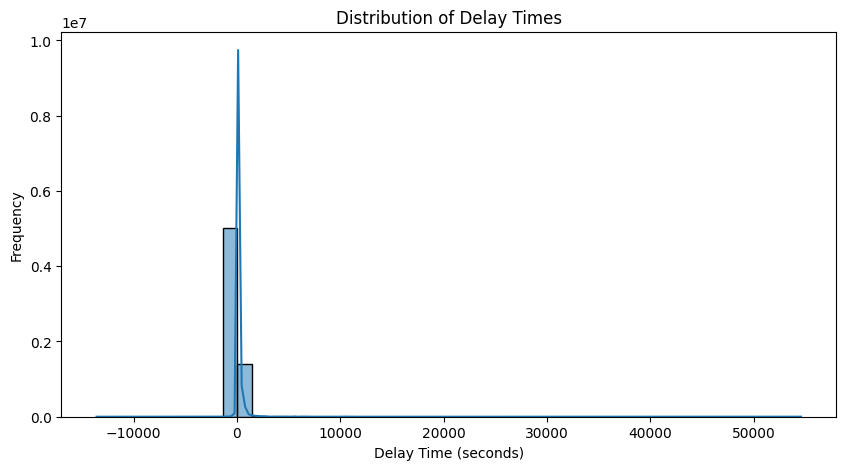

In [97]:
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(stm_trips_df['delay'], bins=50, kde=True)
plt.title('Distribution of Delay Times')
plt.xlabel('Delay Time (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_histogram.png', bbox_inches='tight')
plt.show()

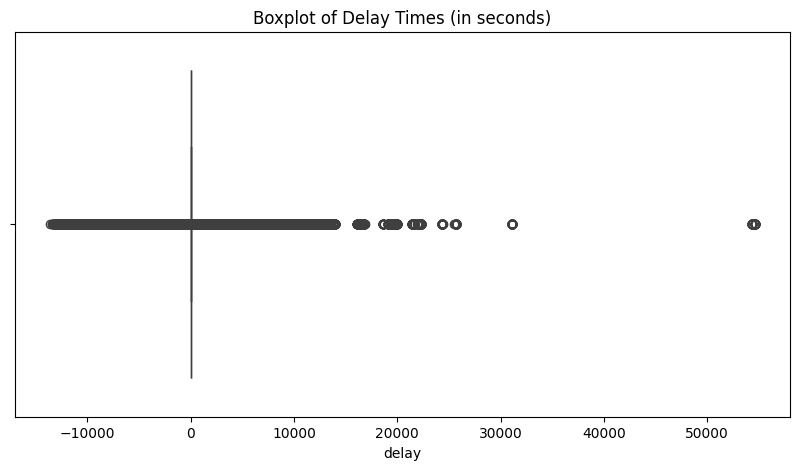

In [98]:
# Plot boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=stm_trips_df['delay'])
plt.title('Boxplot of Delay Times (in seconds)')
plt.savefig('../images/delay_boxplot.png', bbox_inches='tight')
plt.show()

The distribution of delay times is highly skewed, with most values concentrated near 0, but extending both negatively and positively in a wide range. There are extreme outliers stretching up to 55000 seconds (more than 15 hours) and also negative values going beyond -10000 seconds (almost 3 hours). Such extreme alues are unrealistic for transit delays. It's very likely they represent data entry errors, sensor glitches or edge cases (canceled trips, detours, etc.).

In [99]:
# Get rows where delay is bigger than the expected trip duration
outlier_mask = np.abs(stm_trips_df['delay']) > stm_trips_df['exp_trip_duration']
outliers_df = stm_trips_df[outlier_mask]

In [100]:
outliers_df

,current_time,trip_id,route_id,start_date,stop_id,rt_arrival_time,rt_departure_time,schedule_relationship,arrival_time,departure_time,...,wheelchair_boarding,exp_trip_duration,exp_delay_prev_stop,stop_distance,start_date_dt,sch_arrival_time,sch_departure_time,delay,day_of_week,hour
3,1.745791e+09,285076964,212,20250427,58570,NaT,NaT,2,19:00:00,19:00:00,...,2,600.0,0.0,0.000000,2025-04-27,2025-04-27 23:00:00+00:00,2025-04-27 23:00:00+00:00,3298.411765,6,23
296,1.745791e+09,284214978,124,20250427,61371,NaT,2025-04-28 01:00:09+00:00,0,19:00:00,19:00:00,...,2,2100.0,0.0,0.000000,2025-04-27,2025-04-27 23:00:00+00:00,2025-04-27 23:00:00+00:00,7209.000000,6,23
297,1.745791e+09,284214978,124,20250427,55762,2025-04-28 01:01:34+00:00,2025-04-28 01:01:34+00:00,0,19:01:25,19:01:25,...,1,2100.0,85.0,507.598882,2025-04-27,2025-04-27 23:01:25+00:00,2025-04-27 23:01:25+00:00,7209.000000,6,23
298,1.745791e+09,284214978,124,20250427,55758,2025-04-28 01:02:25+00:00,2025-04-28 01:02:25+00:00,0,19:02:16,19:02:16,...,1,2100.0,51.0,355.576442,2025-04-27,2025-04-27 23:02:16+00:00,2025-04-27 23:02:16+00:00,7209.000000,6,23
299,1.745791e+09,284214978,124,20250427,55753,2025-04-28 01:03:21+00:00,2025-04-28 01:03:21+00:00,0,19:03:12,19:03:12,...,1,2100.0,56.0,463.292875,2025-04-27,2025-04-27 23:03:12+00:00,2025-04-27 23:03:12+00:00,7209.000000,6,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6450469,1.746637e+09,285071936,212,20250507,58592,NaT,NaT,2,13:26:00,13:26:00,...,2,780.0,0.0,0.000000,2025-05-07,2025-05-07 17:26:00+00:00,2025-05-07 17:26:00+00:00,4541.478261,2,17
6452693,1.746637e+09,286573025,112,20250507,56848,NaT,NaT,1,13:49:15,13:49:15,...,1,2100.0,52.0,245.271849,2025-05-07,2025-05-07 17:49:15+00:00,2025-05-07 17:49:15+00:00,2162.000000,2,17
6452694,1.746637e+09,286573025,112,20250507,56828,NaT,NaT,1,13:50:18,13:50:18,...,1,2100.0,63.0,415.468045,2025-05-07,2025-05-07 17:50:18+00:00,2025-05-07 17:50:18+00:00,2162.000000,2,17
6456400,1.746637e+09,285071935,212,20250507,58570,NaT,NaT,2,13:11:00,13:11:00,...,2,600.0,0.0,0.000000,2025-05-07,2025-05-07 17:11:00+00:00,2025-05-07 17:11:00+00:00,4538.869565,2,17


If a transit delay is higher than the expected trip duration, it is most likely that something unusual happened.

In [101]:
# Calculate proportion
print(f'{outlier_mask.mean():.2%}')

0.30%


In [102]:
# Remove outliers
stm_trips_df = stm_trips_df[~outlier_mask]

In [103]:
# Get new distribution
stm_trips_df['delay'].describe()

count    6.438459e+06
mean     5.418075e+01
std      1.740505e+02
min     -4.704000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      1.250000e+00
max      4.147000e+03
Name: delay, dtype: float64

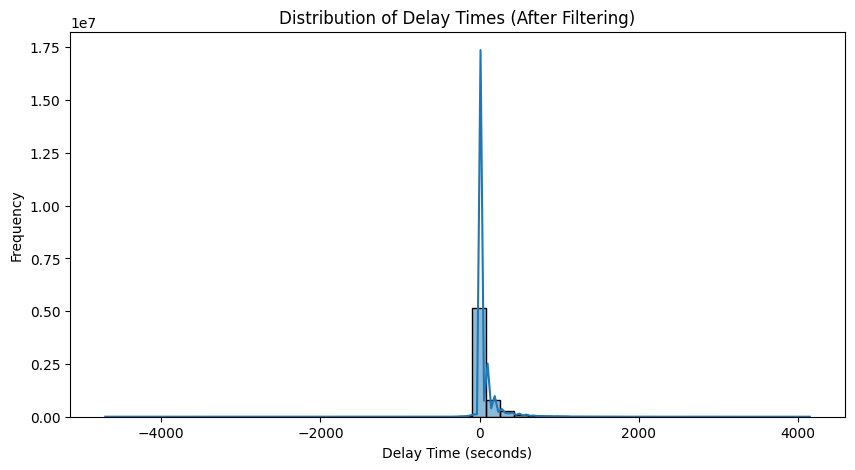

In [104]:
# Replot histogram
plt.figure(figsize=(10, 5))
sns.histplot(stm_trips_df['delay'], bins=50, kde=True)
plt.title('Distribution of Delay Times (After Filtering)')
plt.xlabel('Delay Time (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_histogram_filtered.png', bbox_inches='tight')
plt.show()

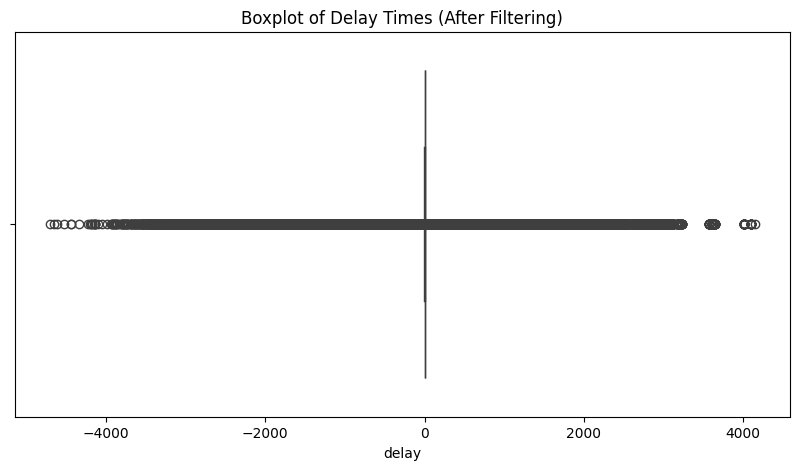

In [105]:
# Replot boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=stm_trips_df['delay'])
plt.title('Boxplot of Delay Times (After Filtering)')
plt.savefig('../images/delay_boxplot_filtered.png', bbox_inches='tight')
plt.show()

In [ ]:
stm_trips_df.columns

In [ ]:
# Remove uneeded columns
stm_trips_df = stm_trips_df.drop(['current_time', 'arrival_time', 'departure_time', 'start_date_dt', 'day_of_week', 'hour', 'trip_start', 'trip_end'], axis=1)

### Trips and Traffic Data

In [ ]:
# Get proportion of duplicates
duplicate_mask = traffic_df.duplicated()
print(f'{duplicate_mask.mean():.2%}')

In [ ]:
# Remove duplicates
traffic_df = traffic_df.drop_duplicates(keep='last').reset_index(drop=True)

In [ ]:
# Convert traffic start_time and end_time to datetime
traffic_df['start_time'] = pd.to_datetime(traffic_df['start_time'], utc=True)
traffic_df['end_time'] = pd.to_datetime(traffic_df['end_time'], utc=True)

In [ ]:
# Sort by date
traffic_df = traffic_df.sort_values(by='start_time').reset_index(drop=True)

In [ ]:
# Fill null end times with current time (assuming the incident is still ongoing)
traffic_df['end_time'] = traffic_df['end_time'].fillna(datetime.now(timezone.utc).replace(microsecond=0))
assert traffic_df['end_time'].isna().sum() == 0

In [ ]:
# Create GeoDataFrame for trip updates
stm_trips_gdf = gpd.GeoDataFrame(
  stm_trips_df,
  geometry=gpd.points_from_xy(stm_trips_df['stop_lon'], stm_trips_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [ ]:
# Create GeoDataFrame for traffic incidents
traffic_gdf = gpd.GeoDataFrame(
    traffic_df,
    geometry=gpd.points_from_xy(traffic_df['longitude'], traffic_df['latitude']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

In [ ]:
# Perform spatial join with nearest incidents
joined = gpd.sjoin_nearest(
  left_df=stm_trips_gdf,
  right_df=traffic_gdf,
  how='left',
  max_distance=500, # get incidents within 500 m
  distance_col='distance')

In [ ]:
joined.columns

In [ ]:
# Filter joined incidents by time overlap
active_incident = (joined['start_time'] <= joined['sch_arrival_time']) & (joined['end_time'] >= joined['sch_arrival_time'])
joined = joined[active_incident].copy()

In [ ]:
# Group by trip index (from trip_gdf) to attach traffic features
incident_summary = joined.groupby('index_right').agg({
	'category': pd.Series.mode,
	'delay_right': 'mean',
   	'distance': 'mean',
	'magnitude_of_delay': pd.Series.mode,
	'geometry': 'count'  # number of incidents
}).rename(columns={
	'category': 'incident_category',
	'delay_right': 'incident_avg_delay',
  	'distance': 'avg_distance_to_incident',
  	'magnitude_of_delay': 'incident_delay_magnitude',
	'geometry': 'incident_count',
})

In [ ]:
# Create boolean column incident_nearby
incident_summary['incident_nearby'] = (incident_summary['incident_count'] > 0).astype('int64')

In [ ]:
# Merge back to original trip_updates
trips_traffic_df = stm_trips_gdf.reset_index().merge(incident_summary, left_index=True, right_on='index_right', how='left')

In [ ]:
# Fill missing values for trips with no incidents
trips_traffic_df = trips_traffic_df.fillna({
	'incident_category': np.nan,
	'incident_delay': np.nan,
	'avg_distance_to_incident': np.nan,
  	'incident_delay_magnitude': np.nan,
	'incident_count': 0,
	'incident_nearby': 0
})

In [ ]:
# Drop uneeded columns
trips_traffic_df = trips_traffic_df.drop(columns=['geometry', 'index_right', 'index'], axis=1)

### Vehicle Positions

In [ ]:
# Check if a trip_id is associated with multiple dates
trips_traffic_df.groupby('trip_id')['start_date'].nunique().sort_values(ascending=False)

In [ ]:
positions_df.dtypes

In [ ]:
# Convert start_date to int
positions_df['start_date'] = positions_df['start_date'].astype('int64')

In [ ]:
# Get proportion of duplicates
subset = ['timestamp', 'trip_id', 'start_date', 'stop_sequence']
duplicate_mask = positions_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

In [ ]:
# Drop duplicates
positions_df = positions_df.drop_duplicates(subset=subset, keep='last')

In [ ]:
# Rename latitude and longitude
positions_df = positions_df.rename(columns={
  'latitude': 'vehicle_lat',
  'longitude': 'vehicle_lon',
  'status': 'vehicle_status',
  'bearing': 'vehicle_bearing',
  'speed': 'vehicle_speed',
  'timestamp': 'vehicle_dt'
})

In [ ]:
# Merge positions
stm_trips_positions_df = pd.merge(left=trips_traffic_df, right=positions_df, how='inner', on=['trip_id', 'start_date', 'stop_sequence']) \
	.rename(columns={'route_id_x': 'route_id'}) \
	.drop(['current_time', 'route_id_y', 'start_date_x', 'start_date_y', 'start_time'], axis=1)

In [ ]:
stm_trips_positions_df.columns

In [ ]:
# Create GeoDataFrames for vehicle and stop positions
pos_gdf1 = gpd.GeoDataFrame(
  stm_trips_positions_df[['vehicle_lon', 'vehicle_lat']],
  geometry=gpd.points_from_xy(stm_trips_positions_df['vehicle_lon'], stm_trips_positions_df['vehicle_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

pos_gdf2 = gpd.GeoDataFrame(
  stm_trips_positions_df[['stop_lon', 'stop_lat']],
  geometry=gpd.points_from_xy(stm_trips_positions_df['stop_lon'], stm_trips_positions_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [ ]:
# Calculate the vehicle distance from the current stop
stm_trips_positions_df['vehicle_distance'] = pos_gdf1.distance(pos_gdf2)
stm_trips_positions_df['vehicle_distance'].describe()

In [ ]:
# The large vehicle distances don't seem to make sense with the delays, the coordinates and distance won't be used
further_than_previous_stop = stm_trips_positions_df['vehicle_distance'] > stm_trips_positions_df['stop_distance']
stm_trips_positions_df[further_than_previous_stop].sort_values('vehicle_distance', ascending=False)

### Service Alerts

In [ ]:
# Get proportion of duplicates
duplicate_mask = alerts_df.duplicated()
print(f'{duplicate_mask.mean():.2%}')

In [ ]:
# Remove duplicates
alerts_df = alerts_df.drop_duplicates(keep='last').reset_index(drop=True)

In [ ]:
# Convert timestamps to datetime
alerts_df['start_time'] = pd.to_datetime(alerts_df['start_time'], origin='unix', unit='s', utc=True)
alerts_df['end_time'] = pd.to_datetime(alerts_df['end_time'], origin='unix', unit='s', utc=True)

In [ ]:
# Fill null end times with current dates (assuming the alert is still active)
alerts_df['end_time'] = alerts_df['end_time'].fillna(datetime.now(timezone.utc).replace(microsecond=0))

In [ ]:
# Sort values by start time
alerts_df = alerts_df.sort_values('start_time').reset_index(drop=True)

In [ ]:
# Merge alerts
stm_df = pd.merge(left=stm_trips_positions_df, right=alerts_df, how='left', on=['route_id', 'stop_id'])

In [ ]:
# Add boolean column if the stop as an active alert
has_alert_mask = (stm_df['start_time'].notna()) & \
	(stm_df['sch_arrival_time'] >= stm_df['start_time']) & \
	(stm_df['sch_arrival_time'] <= stm_df['end_time'])
stm_df['stop_has_alert'] = has_alert_mask.astype('int64')

In [ ]:
stm_df['stop_has_alert'].value_counts()

In [ ]:
stm_df.columns

In [ ]:
# Drop unneeded datetime columns
stm_df = stm_df.drop(['start_time', 'end_time'], axis=1)

### Route Types

In [ ]:
stm_df = pd.merge(left=stm_df, right=routes_df, how='inner', on='route_id')

In [ ]:
stm_df.columns

### STM and Weather

In [ ]:
# Convert time string to datetime
time_dt = pd.to_datetime(weather_df['time'], utc=True)

In [ ]:
# Calculate dates for weather forecast
last_day_weather = time_dt.max()
start_date = last_day_weather + timedelta(days=1)
end_date = stm_df['sch_arrival_time'].max()

In [ ]:
# Fetch forecast weather
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

forecast_list = fetch_weather(start_date=start_date_str, end_date=end_date_str, forecast=True)
forecast_df = pd.DataFrame(forecast_list)

In [ ]:
# Merge archive and forecast weather
weather_df = pd.concat([weather_df, forecast_df], ignore_index=True)

In [ ]:
weather_df.info()

In [ ]:
# Drop visibility column because most of the values are null
weather_df = weather_df.drop('visibility', axis=1)

In [ ]:
# Round arrival time to the nearest hour
rounded_arrival_dt = stm_df['sch_arrival_time'].dt.round('h')

In [ ]:
# Format time to match weather data
stm_df['time'] = rounded_arrival_dt.dt.strftime('%Y-%m-%dT%H:%M')

In [ ]:
# Merge STM with weather
df = pd.merge(left=stm_df, right=weather_df, how='inner', on='time').drop('time', axis=1)

## Clean Data

### Drop Columns

In [ ]:
# Remove columns with constant values or with more than 50% missing values
df = df.loc[:, (df.nunique() > 1) & (df.isna().mean() < 0.5)]
df.columns

In [ ]:
df.isna().sum()

### Convert columns

In [ ]:
# Get columns with two values
two_values = df.loc[:, df.nunique() == 2]
for column in two_values.columns:
  print(df[column].value_counts())

In [ ]:
# Convert columns with 2 unique values to integer
df['wheelchair_boarding'] = (df['wheelchair_boarding'] == 1).astype('int64')
df['vehicle_in_transit'] = (df['vehicle_status'] == 2).astype('int64')
df['incident_nearby'] = df['incident_nearby'].astype('int64')

### Create Delay Categories

**Delay Threshholds, according to [STM's definition](https://www.stm.info/en/info/networks/bus-network-and-schedules-enlightened)**

- Early: delay < -1 min
- On Time: -1 min ≤ delay < 3 min
- Late: delay ≥ 3 min

In [ ]:
# Add delay category column
labels = ['Early', 'On Time', 'Late']
ranges = [-np.inf, -60, 180, np.inf]
df['delay_class'] = pd.cut(df['delay'], bins=ranges, labels=labels, include_lowest=True, right=False)
df['delay_class'].value_counts(normalize=True)

### Convert schedule_relationship and occupancy_status to Categories

In [ ]:
def convert_to_categories(df:pd.DataFrame, column:str, map_dict:dict) -> pd.Series:
	codes = df[column].sort_values().unique()
	condition_list = []
	label_list = []
		
	for code in codes:
		condition_list.append(df[column] == code)
		label_list.append(map_dict[code])
	
	df[column] = np.select(condition_list, label_list, default='Unknown')
	return df[column]

In [ ]:
df['schedule_relationship'] = convert_to_categories(df, 'schedule_relationship', SCHEDULE_RELATIONSHIP)
df['schedule_relationship'].value_counts()

In [ ]:
df['occupancy_status'] = convert_to_categories(df, 'occupancy_status', OCCUPANCY_STATUS)
df['occupancy_status'].value_counts()

## Export Data

In [ ]:
df.columns

In [ ]:
# Drop and reorder columns
df = df[[
	'trip_id',
  	'exp_trip_duration',
	'vehicle_id',
  	'vehicle_bearing',
	'vehicle_speed',
	'vehicle_in_transit',
	'occupancy_status',
  	'route_id',
    'route_type',
  	'stop_id',
    'stop_name',
    'stop_lat',
    'stop_lon',
    'stop_distance',
    'stop_sequence',
    'trip_progress',
    'stop_has_alert',
    'schedule_relationship',
	'wheelchair_boarding',
  	'rt_arrival_time',
	'rt_departure_time',
  	'sch_arrival_time',
    'sch_departure_time',
    'delay',
    'delay_class',
    'exp_delay_prev_stop',
    'incident_count',
    'incident_nearby',
	'temperature',
    'relative_humidity',
  	'dew_point',
  	'precipitation',
  	'pressure',
	'cloud_cover',
  	'windspeed',
  	'wind_direction',
  	'wind_gusts'
]]

In [ ]:
# Export data to CSV
df.to_parquet('../data/stm_weather_traffic_merged.parquet', index=False)

## End